# Private Load Shape Algorithm Design #

A common visualization in the energy efficiency sector is the "average load shape", like this one from the California ISO (CAISO):

![CAISO Example Load Shape](caiso-load-shape.png "CAISO Example Load Shape")

A load shape is the trace of energy usage over a given time period. It is useful at a number of timescales (hourly, daily, weekly). An average load shape averages the load shapes of a number of buildings together to understand overall energy usage patterns for a population.

What differential privacy mechanism is best suited for average load shapes?

In [1]:
# Preamble: imports and figure settings

from eeprivacy import (
  PrivateVectorClampedMeanLaplace,
  PrivateVectorClampedMeanGaussian,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy import stats

np.random.seed(1234) # Fix seed for deterministic documentation

mpl.style.use("seaborn-whitegrid")

MD = 28
LG = 36
plt.rcParams.update({
    "figure.figsize": [25, 25],
    "legend.fontsize": MD,
    "axes.labelsize": LG,
    "axes.titlesize": LG,
    "xtick.labelsize": LG,
    "ytick.labelsize": LG,
})

## A Semantic Model for Load Shapes ##

The first challenge that private load shapes presents is determining an appropriate sematic model of privacy. That is, since each figure contains multiple data points per individual building, how should privacy budget be allocated per data point?

If data points in a time series figure are not correlated, then privacy budget can be reset between each data point. For an overall $\epsilon_G$, each data point's $\epsilon_i = \epsilon_G$.

However, if data points are correlated, then the value from one point in time in the figure could be used to undermine the privacy protection of another. The privacy budget $\epsilon_G$ must be shared over the entire set of points in the figure.

Perhaps at some time resolutions, data are highly correlated, but, at others, they are not. Minutely energy data would exhibit high correlation, while annual average consumption would exhibit much less.

In this example, we adopt a strict semantic model: privacy budget is never reset.

A few examples of privacy harms from energy data suggest that this is necessary:

* Occupancy is highly correlated across days
* Average energy consumption is highly correlated across days

In a previous example, we considered the case of a high profile environmentalist being embarrassed by secretly high energy consumption. This high energy consumption would be apparent at almost any hour of the day. 

Therefore, we must bound privacy loss to the entire time series.

## Candidate Mechanisms ##

We will compare two mechanisms for private load shapes:
  
1. Laplace Mechanism
2. Gaussian Mechanism

The Laplace Mechanism adds less noise per data point than the Gaussian Mechanism, but the noise is scaled to the L1 norm of the dataset rather than the L2 norm.

For a small number of points per building per figure, the Laplace Mechanism will outperform the Gaussian Mechanism. As the number of points increases, the Gaussian Mechanism's L2 scaling will overtake the accuracy benefit of the Laplace Mechanism.

## Sample Data Set ##

We will consider queries against a residential energy consumption dataset.

A reasonable upper bound for household energy consumption is 2 kWh, which translates into a sensitivity $\Delta$ = 2.

We are interested in average load shapes across a variety of time ranges -- hourly, weekly, and daily -- at the hourly resolution.

* Daily: An average day's energy consumption, 24 points per building
* Weekly: An average week's energy consumption, 168 points per building
* Monthly: An average houry's energy consumption, 672 points per building

We will consider a variety of population sizes from 100 to 100,000 buildings.

Finally, we will seek an error of +/- 0.1 kWh per hour at 95% confidence.



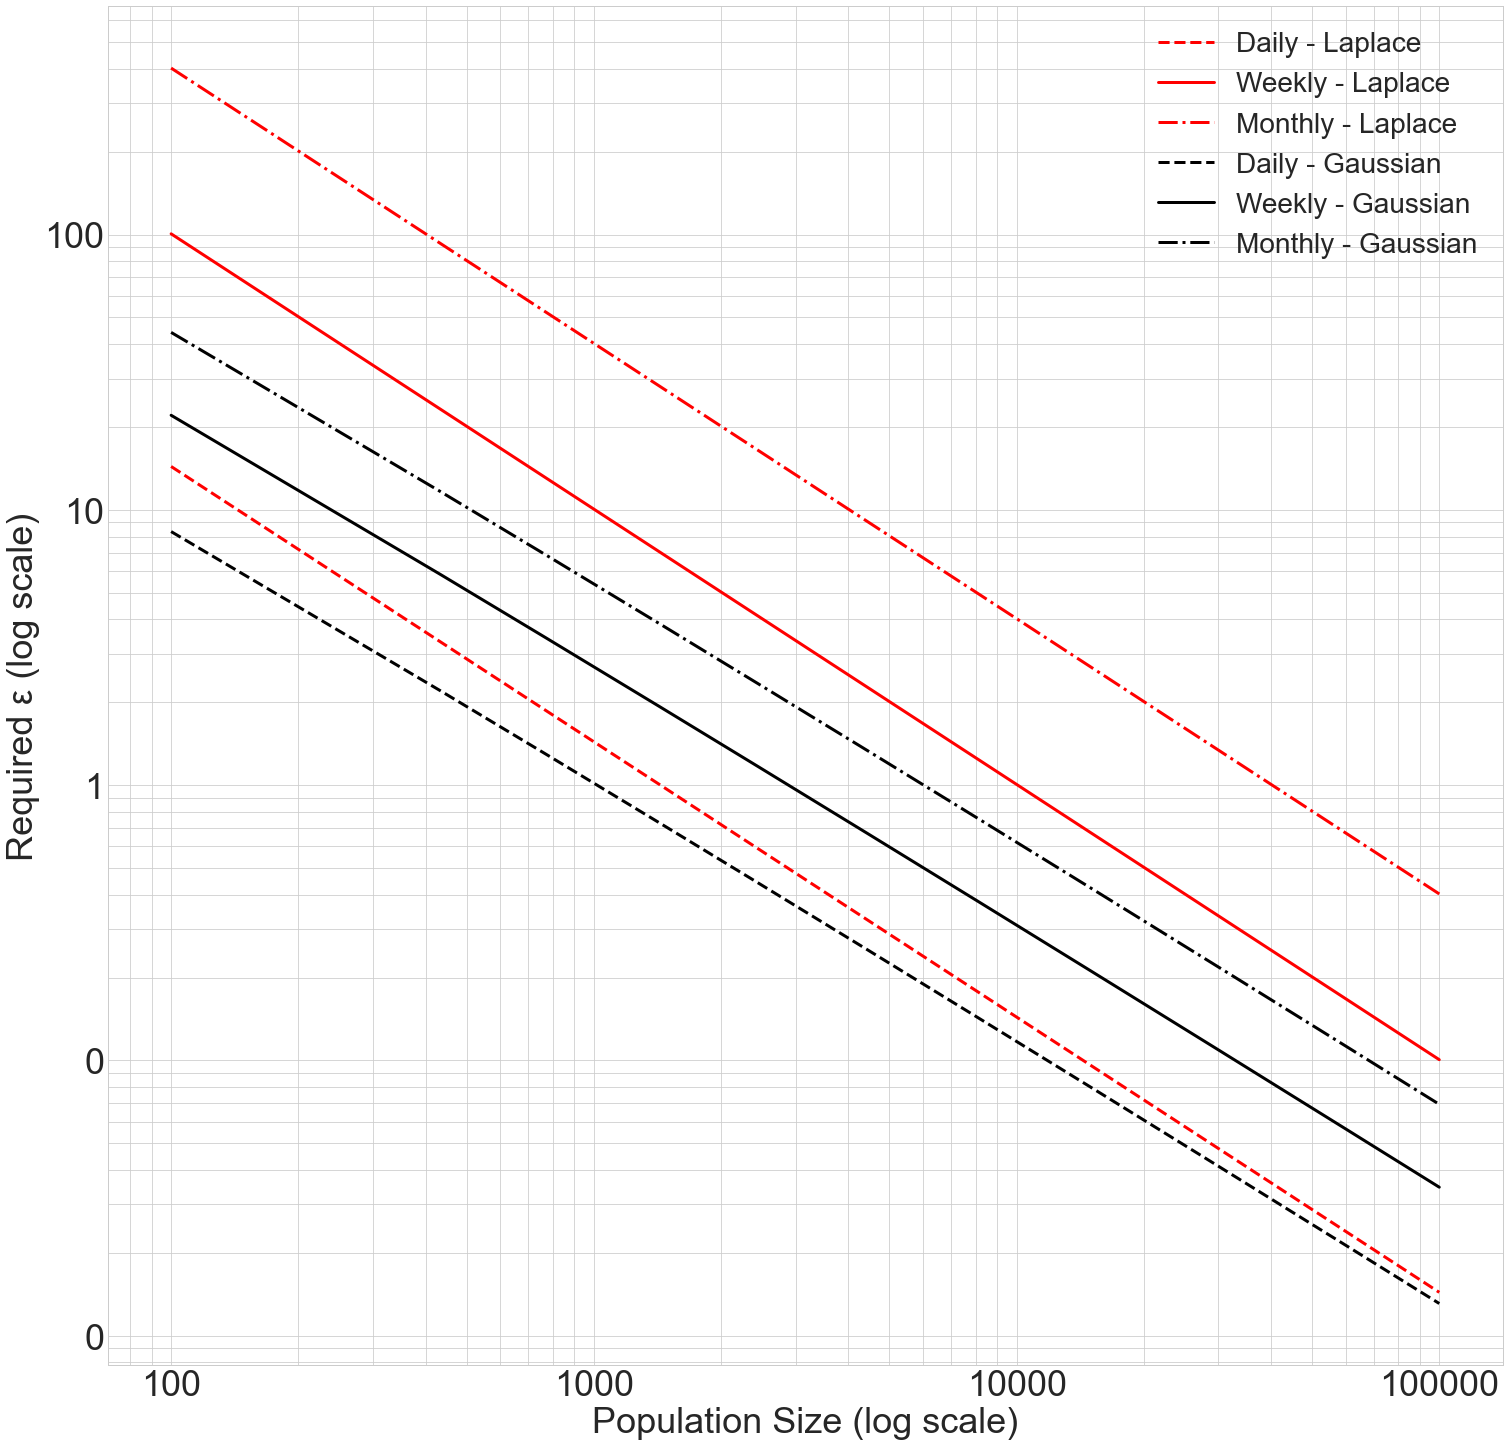

In [2]:
x = np.linspace(100, 100000, num=300)

def epsilons(points_per_building=0):
  ret = []
  for N in x:
    private_mean_op = PrivateVectorClampedMeanLaplace(
      lower_bound = 0,
      upper_bound = 2,
      k = points_per_building,
      N = N
    )
    ci = private_mean_op.epsilon_for_confidence_interval(
      target_ci = 0.1,
      confidence = 0.95
    )
    ret.append(ci)
  return ret

daily_epsilons_laplace = epsilons(points_per_building=24)
weekly_epsilons_laplace = epsilons(points_per_building=168)
monthly_epsilons_laplace = epsilons(points_per_building=672)

def epsilons(points_per_building=0):
  ret = []
  for N in x:
    private_mean_op = PrivateVectorClampedMeanGaussian(
      lower_bound = 0,
      upper_bound = 2,
      k = points_per_building,
      N = N
    )
    ci = private_mean_op.epsilon_for_confidence_interval(
      target_ci = 0.1,
      confidence = 0.95,
      delta = 1/(N**2)
    )
    ret.append(ci)
  return ret
    
daily_epsilons_gaussian = epsilons(points_per_building=24)
weekly_epsilons_gaussian = epsilons(points_per_building=168)
monthly_epsilons_gaussian = epsilons(points_per_building=672)

fig, ax = plt.subplots()

ax.plot(x, daily_epsilons_laplace, 
        label="Daily - Laplace", color="r", linestyle="dashed", linewidth=3)
ax.plot(x, weekly_epsilons_laplace, 
        label="Weekly - Laplace", color="r", linestyle="solid", linewidth=3)
ax.plot(x, monthly_epsilons_laplace, 
        label="Monthly - Laplace", color="r", linestyle="dashdot", linewidth=3)
ax.plot(x, daily_epsilons_gaussian, 
        label="Daily - Gaussian", color="k", linestyle="dashed", linewidth=3)
ax.plot(x, weekly_epsilons_gaussian, 
        label="Weekly - Gaussian", color="k", linestyle="solid", linewidth=3)
ax.plot(x, monthly_epsilons_gaussian, 
        label="Monthly - Gaussian", color="k", linestyle="dashdot", linewidth=3)

ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel("Population Size (log scale)")
plt.ylabel("Required ε (log scale)")
plt.legend()

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(FormatStrFormatter("%.0f"))

ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')


plt.show()

## Accuracy/Privacy Trade-Off of Approaches ##

For all of the load shape scenarios considered in this analysis, the Gaussian Mechanism outperforms the Laplace Mechanism, requiring less privacy budget for a given level of accuracy.